# **PyTorch for Stock Price Prediction**
https://h2o.ai/blog/2022/a-quick-introduction-to-pytorch-using-deep-learning-for-stock-price-prediction/

In [ ]:
%%bash
unzip LLM_TRAIN/archive.zip


In [1]:
import pandas as pd
df = pd.read_csv("LLM_TRAIN/prices-split-adjusted.csv", index_col = 0)
# We will use EQIX for this tutorial:
df = df[df.symbol == 'EQIX']
df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,EQIX,106.519997,109.559998,106.510002,109.620003,576300.0
2010-01-05,EQIX,109.589996,108.540001,108.379997,109.589996,681900.0
2010-01-06,EQIX,108.949997,109.529999,108.220001,110.570000,1397500.0
2010-01-07,EQIX,109.250000,107.290001,106.639999,110.349998,797200.0
2010-01-08,EQIX,106.800003,106.769997,105.900002,107.279999,432400.0


In [2]:
df.shape

(1762, 6)

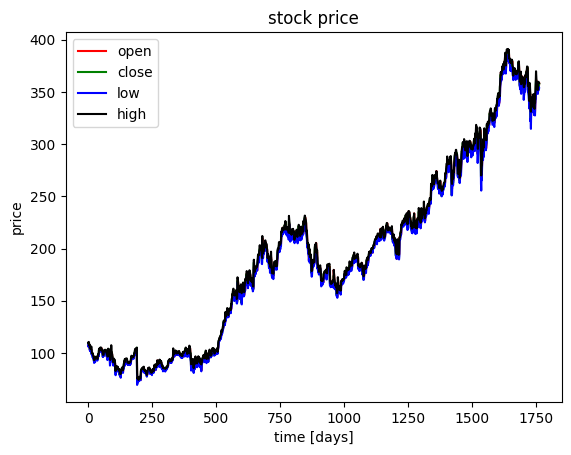

In [3]:
import matplotlib.pyplot as plt
plt.plot(df.open.values, color='red', label='open')
plt.plot(df.close.values, color='green', label='close')
plt.plot(df.low.values, color='blue', label='low')
plt.plot(df.high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')


## Data Normalization

In [4]:
import sklearn.preprocessing
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
df['close'] = min_max_scaler.fit_transform(df.close.values.reshape(-1,1))
data = df[['open','close','low','high']].values
data.shape

(1762, 4)

## Preparing Data for Time Series
In order to prepare the dataset for stock price prediction, we need to frame it as a time series problem. We will use the price from the previous 19 days to predict the price on the next day. Let’s create the sequences accordingly:

In [5]:
import numpy as np
seq_len=20
sequences=[]

for index in range(len(data) - seq_len):
    sequences.append(data[index: index + seq_len])
sequences= np.array(sequences)
sequences[0]

array([[0.10925029, 0.12290433, 0.11744033, 0.11091105],
       [0.11889648, 0.11970795, 0.12336141, 0.11081625],
       [0.11688555, 0.12281032, 0.1228548 , 0.11391205],
       [0.11782819, 0.1157908 , 0.11785195, 0.11321707],
       [0.11013009, 0.11416126, 0.11550885, 0.10351907],
       [0.11066424, 0.11691894, 0.11804192, 0.10626737],
       [0.10950166, 0.10325594, 0.10619974, 0.10468789],
       [0.09583359, 0.10259786, 0.10395163, 0.09429492],
       [0.09919562, 0.10585693, 0.10733963, 0.09559008],
       [0.10252622, 0.09955816, 0.10173518, 0.094674  ],
       [0.09721612, 0.10526152, 0.10189349, 0.09366313],
       [0.09771884, 0.10375732, 0.10306505, 0.09325245],
       [0.09878716, 0.10350664, 0.10670637, 0.10029694],
       [0.09881856, 0.08987496, 0.09261605, 0.09397902],
       [0.08800981, 0.09322804, 0.09397758, 0.0839967 ],
       [0.08687866, 0.0912538 , 0.09293268, 0.08112206],
       [0.08530761, 0.09059573, 0.08992465, 0.0791951 ],
       [0.08615596, 0.0859265 ,

In [6]:
valid_set_size_percentage = 10
test_set_size_percentage = 10

valid_set_size = int(np.round(valid_set_size_percentage/100*sequences.shape[0]))
test_set_size = int(np.round(test_set_size_percentage/100*sequences.shape[0]))
train_set_size = sequences.shape[0] - (valid_set_size + test_set_size)

x_train = sequences[:train_set_size,:-1,:]
y_train = sequences[:train_set_size,-1,:]

x_valid = sequences[train_set_size:train_set_size+valid_set_size,:-1,:]
y_valid = sequences[train_set_size:train_set_size+valid_set_size,-1,:]

x_test = sequences[train_set_size+valid_set_size:,:-1,:]
y_test = sequences[train_set_size+valid_set_size:,-1,:]

## Creating Data Loaders
Next, we define the data loaders to load the dataset in batches:

In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader

x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

x_valid = torch.tensor(x_valid).float()
y_valid = torch.tensor(y_valid).float()

train_dataset = TensorDataset(x_train,y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = TensorDataset(x_valid,y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

## Defining Model Architecture
We will define the model architecture by subclassing the nn (Neural Networks) module. As it’s a time series problem, we will use Long Short-term Memory (LSTM) to capture the sequential information:

In [8]:
from torch import nn
from torch.nn import LSTM, Linear


class NeuralNetwork(nn.Module):

    def __init__(self):

        super(NeuralNetwork, self).__init__()
        self.lstm = LSTM(input_size=4, hidden_size=64, batch_first=True)
        self.fc = Linear(in_features=64, out_features=4)


    def forward(self, x):
        output, (hidden, cell_lstm) = self.lstm(x)
        x = self.fc(hidden)
        return x



model = NeuralNetwork()



# push to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = model.to(device)

In [9]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())
mse = nn.MSELoss()


def train(dataloader: DataLoader):
    epoch_loss = 0

    # set model in training mode
    model.train()

    for batch in dataloader:
        optimizer.zero_grad()  # set in zero the gradients in each batch
        x, y = batch
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = mse(pred[0], y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss


def evaluate(dataloader: DataLoader):
    epoch_loss = 0
    model.eval()

    with torch.no_grad():  # in this case isn't need the gradients
        for batch in dataloader:

            x, y = batch
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = mse(pred[0], y)
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [10]:
n_epochs = 50
best_valid_loss = float('inf')

for epoch in range(n_epochs):

    train_loss = train(train_dataloader)
    valid_loss = evaluate(valid_dataloader)

# save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, 'saved_weights.pt')

    print("Epoch ", epoch+1)
    print(f'\tTrain Loss: {train_loss:.5f}')
    print(f'\tVal Loss: {valid_loss:.5f}\n')

Epoch  1
	Train Loss: 1.64719
	Val Loss: 0.00323

Epoch  2
	Train Loss: 0.08569
	Val Loss: 0.00379

Epoch  3
	Train Loss: 0.02316
	Val Loss: 0.00084

Epoch  4
	Train Loss: 0.01515
	Val Loss: 0.00100

Epoch  5
	Train Loss: 0.01320
	Val Loss: 0.00185

Epoch  6
	Train Loss: 0.01218
	Val Loss: 0.00205

Epoch  7
	Train Loss: 0.01263
	Val Loss: 0.00217

Epoch  8
	Train Loss: 0.01113
	Val Loss: 0.00140

Epoch  9
	Train Loss: 0.01146
	Val Loss: 0.00123

Epoch  10
	Train Loss: 0.01081
	Val Loss: 0.00125

Epoch  11
	Train Loss: 0.01013
	Val Loss: 0.00143

Epoch  12
	Train Loss: 0.00984
	Val Loss: 0.00118

Epoch  13
	Train Loss: 0.00930
	Val Loss: 0.00112

Epoch  14
	Train Loss: 0.00956
	Val Loss: 0.00135

Epoch  15
	Train Loss: 0.00906
	Val Loss: 0.00107

Epoch  16
	Train Loss: 0.00938
	Val Loss: 0.00157

Epoch  17
	Train Loss: 0.00847
	Val Loss: 0.00094

Epoch  18
	Train Loss: 0.00897
	Val Loss: 0.00077

Epoch  19
	Train Loss: 0.00825
	Val Loss: 0.00060

Epoch  20
	Train Loss: 0.00817
	Val Loss

## Inference

In [16]:
import torch 
model=torch.load('saved_weights.pt')
model.to(device)

# x_test= torch.tensor(x_test.copy()).float()
x_test = x_test.to(device)

with torch.no_grad():
    y_test_pred = model(x_test)

# .cpu() es necesario porque NumPy no puede manejar tensores que están en la GPU
y_test_pred = y_test_pred.cpu().numpy()[0]


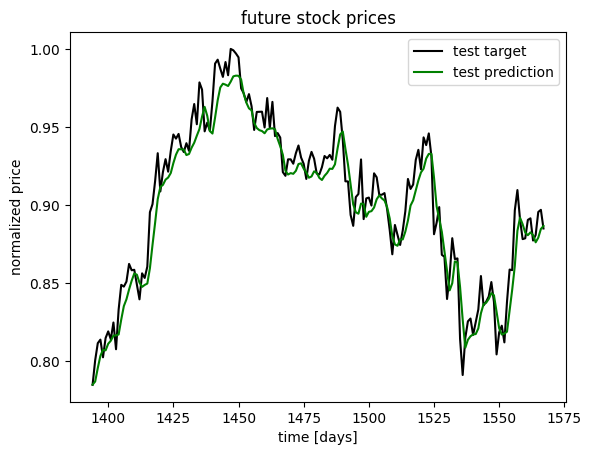

In [17]:
idx=0
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
y_test[:,idx], color='black', label='test target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test_pred.shape[0]),
y_test_pred[:,idx], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')